IMPORTING THE REQUIRED PACKAGES

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os
import glob
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import math

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
#from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
from keras import optimizers

In [110]:
dir = 'dataset'
listdir = os.listdir(dir)

print(listdir)
print("The number of dataset :", len(listdir))

['B05_discharge_soh.csv', 'B07_discharge_soh.csv', 'B18_discharge_soh.csv', 'B33_discharge_soh.csv', 'B34_discharge_soh.csv', 'B46_discharge_soh.csv', 'B47_discharge_soh.csv', 'B48_discharge_soh.csv']
The number of dataset : 8


In [111]:
num = ['B05', 'B07', 'B18', 'B33', 'B34', 'B46', 'B47', 'B48']
for i in range(len(listdir)):
    vector = np.zeros((1,3))
    path = os.path.join(os.getcwd(), 'dataset/', num[i] + '_discharge_soh.csv')
    csv = pd.read_csv(path)
    df = pd.DataFrame(csv)
    
    vec = df[['cycle', 'capacity', 'SOH']]
    
    globals()['data_{}'.format(num[i])] = vec

In [112]:
data = pd.read_csv('dataset/B05_discharge_soh.csv')
df = pd.DataFrame(data)
df

,terminal_voltage,terminal_current,temperature,charge_current,charge_voltage,time,capacity,cycle,SOH
0,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000,1.856487,1,0.928244
1,4.190749,-0.001478,24.325993,-0.0006,4.206,16.781,1.856487,1,0.928244
2,3.974871,-2.012528,24.389085,-1.9982,3.062,35.703,1.856487,1,0.928244
3,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781,1.856487,1,0.928244
4,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922,1.856487,1,0.928244
...,...,...,...,...,...,...,...,...,...
50280,3.579262,-0.001569,34.864823,0.0006,0.000,2781.312,1.325079,168,0.662540
50281,3.581964,-0.003067,34.814770,0.0006,0.000,2791.062,1.325079,168,0.662540
50282,3.584484,-0.003079,34.676258,0.0006,0.000,2800.828,1.325079,168,0.662540
50283,3.587336,0.001219,34.565580,0.0006,0.000,2810.640,1.325079,168,0.662540


In [113]:
data_B05

,cycle,capacity,SOH
0,1,1.856487,0.928244
1,1,1.856487,0.928244
2,1,1.856487,0.928244
3,1,1.856487,0.928244
4,1,1.856487,0.928244
...,...,...,...
50280,168,1.325079,0.662540
50281,168,1.325079,0.662540
50282,168,1.325079,0.662540
50283,168,1.325079,0.662540


In [114]:
for i in range(len(listdir)):
    print("Shape of data :", np.shape(globals()['data_{}'.format(num[i])]))

Shape of data : (50285, 3)
Shape of data : (50285, 3)
Shape of data : (34866, 3)
Shape of data : (42200, 3)
Shape of data : (45909, 3)
Shape of data : (23478, 3)
Shape of data : (23478, 3)
Shape of data : (23478, 3)


In [115]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_B05[["cycle", "capacity"]] = scaler.fit_transform(data_B05[["cycle", "capacity"]])

In [116]:
print(listdir)
dataset = data_B05[["cycle", "capacity", "SOH"]].values
cycle = data_B05['cycle']

dataset = np.array(dataset)
#dataset = dataset.reshape((len(dataset),1))
dataset.shape

['B05_discharge_soh.csv', 'B07_discharge_soh.csv', 'B18_discharge_soh.csv', 'B33_discharge_soh.csv', 'B34_discharge_soh.csv', 'B46_discharge_soh.csv', 'B47_discharge_soh.csv', 'B48_discharge_soh.csv']


(50285, 3)

CREATING TESTS AND TRAIN DATASETS

In [117]:
train_size = int(len(dataset) * 0.8)
# train_size = int(len(dataset) * 0.5)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

40228 10057


In [118]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :-1]
        dataX.append(a)
        dataY.append(dataset[i + look_back, -1])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [119]:
def create_dataset_no_lookback(dataset):
    
    # Inputs: all columns except the last one (cycle and capacity)
    dataX = dataset[:, :-1]
    
    # Target: the last column (SOH)
    dataY = dataset[:, -1]
    
    return np.array(dataX), np.array(dataY)


In [120]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

40227
10056


In [121]:
# Assuming `dataset` has been preprocessed and contains [cycle, capacity, SoH]
# dataX, dataY = create_dataset_no_lookback(dataset)

# # Split into training and testing sets
# train_size = int(len(dataX) * 0.5)
# trainX, testX = dataX[:train_size], dataX[train_size:]
# trainY, testY = dataY[:train_size], dataY[train_size:]

# print("TrainX shape:", trainX.shape)
# print("TrainY shape:", trainY.shape)
# print("TestX shape:", testX.shape)
# print("TestY shape:", testY.shape)


In [122]:

#for rnn with lookback 
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))  # (samples, timesteps, features)
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))  # (samples, timesteps, features)

print(trainX)
print(testX.shape)

[[[0.         1.        ]]

 [[0.         1.        ]]

 [[0.         1.        ]]

 ...

 [[0.80239521 0.14480216]]

 [[0.80239521 0.14480216]]

 [[0.80239521 0.14480216]]]
(10056, 1, 2)


In [123]:
#rnn lookback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import numpy as np

# Assuming 'trainX' and 'trainY' are already created using the lookback method

# Define RNN model
model = Sequential()
model.add(SimpleRNN(64, input_shape=(trainX.shape[1], trainX.shape[2]), activation='relu', return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# Compile and fit the model
model.compile(loss='mae', optimizer='adam')

history = model.fit(trainX, trainY, epochs=100, batch_size=20, validation_data=(testX, testY), verbose=1, shuffle=False)


Epoch 1/100


c:\Users\sidar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2012/2012 ━━━━━━━━━━━━━━━━━━━━ 3s 930us/step - loss: 0.0768 - val_loss: 0.0336
Epoch 2/100
2012/2012 ━━━━━━━━━━━━━━━━━━━━ 2s 853us/step - loss: 0.0036 - val_loss: 0.0255
Epoch 3/100
2012/2012 ━━━━━━━━━━━━━━━━━━━━ 2s 866us/step - loss: 0.0042 - val_loss: 0.0239
Epoch 4/100
2012/2012 ━━━━━━━━━━━━━━━━━━━━ 2s 844us/step - loss: 0.0046 - val_loss: 0.0290
Epoch 5/100
2012/2012 ━━━━━━━━━━━━━━━━━━━━ 2s 830us/step - loss: 0.0036 - val_loss: 0.0265
Epoch 6/100
2012/2012 ━━━━━━━━━━━━━━━━━━━━ 2s 850us/step - loss: 0.0038 - val_loss: 0.0208
Epoch 7/100
2012/2012 ━━━━━━━━━━━━━━━━━━━━ 2s 848us/step - loss: 0.0051 - val_loss: 0.0230
Epoch 8/100
2012/2012 ━━━━━━━━━━━━━━━━━━━━ 2s 853us/step - loss: 0.0046 - val_loss: 0.0273
Epoch 9/100
2012/2012 ━━━━━━━━━━━━━━━━━━━━ 2s 860us/step - loss: 0.0042 - val_loss: 0.0241
Epoch 10/100
2012/2012 ━━━━━━━━━━━━━━━━━━━━ 2s 830us/step - loss: 0.0038 - val_loss: 0.0204
Epoch 11/100
2012/2012 ━━━━━━━━━━━━━━━━━━━━ 2s 875us/step - loss: 0.0038 - val_loss: 0.0253
Epoch 12/

In [124]:
# save model architecture
# save model architecture
#model_json = model.to_json()
#open('50%/model/B05_model.json', 'w').write(model_json)

# save model's learned weights
#model.save_weights('50%/model/B05_weights.weights.h5', overwrite=True)

In [125]:
from keras.models import model_from_json 

#json_file = open("50%/model/B05_model.json", "r")
#loaded_model_json = json_file.read() 
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
 
# model weight load 
#loaded_model.load_weights("50%/model/B05_weights.weights.h5")
#print("Loaded model from disk")

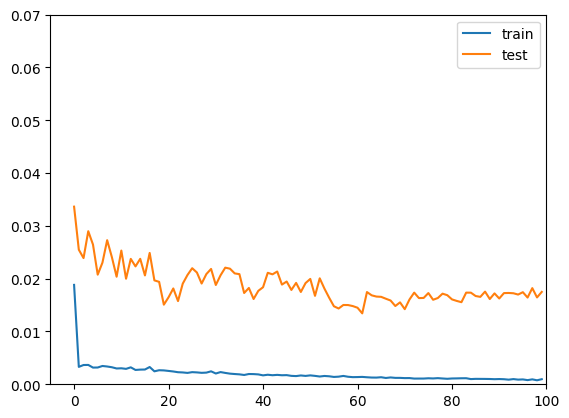

In [126]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.axis([-5, 100, 0, 0.07])
plt.legend() 
plt.show()

315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 1s 589us/step


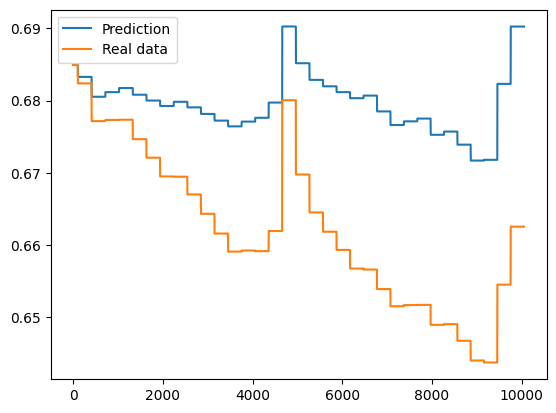

In [127]:
yhat = model.predict(testX)
tyhat = model.predict(trainX)
plt.plot(yhat, label='Prediction')
plt.plot(testY, label='Real data')
plt.legend()
plt.show()

In [128]:
print("Shape of train data :", trainX.shape)
print("Shape of prediction :", yhat.shape)
print("Shape of real data :", testY.shape)

Shape of train data : (40227, 1, 2)
Shape of prediction : (10056, 1)
Shape of real data : (10056,)


In [129]:
rmse = math.sqrt(mean_squared_error(testY, yhat))
mae = mean_absolute_error(testY, yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

Test RMSE: 0.019
Test MAE: 0.017


In [130]:
from sklearn.metrics import r2_score
r2 = r2_score(testY, yhat)
print('Test R² Score: %.3f' % r2)


Test R² Score: -2.269


In [131]:
mape = np.mean(np.abs((testY - yhat) / testY)) * 100
print('Test MAPE: %.3f' % mape)


Test MAPE: 2.750


In [132]:
from sklearn.metrics import median_absolute_error
med_ae = median_absolute_error(testY, yhat)
print('Test Median Absolute Error: %.3f' % med_ae)


Test Median Absolute Error: 0.018
